## **Predicting Smash Bros Characters with a Convolutional Neural Network (CNN)**

One of the best generic models for image recognition is a Convolutional Neural Network. There are many CNN projects out there most of which use standard datasets such as MNIST, IMDB Movie Reviews, CIFAR-10, etc. These are excellent datasets to train a Machine Learning model on, primarily because they are often pre-processed, meaning the data is already cleaned, images are already resized, augmented and manipulated into array representation. All the user has to do is build and train the model. However, in real world problems we are often not given a ready-to-use dataset.
<br> <br>
This project will demonstrate all the steps from obtaining the images to processing the data and to building the prediction model. For the images I used three characters from the Nintendo game, Smash Bros. Why? I don't know, it's fun and honestly if I am going to spend hours on this project I would rather see Pikachu than a zillion type of plants.

### **1. Obtaining the Images**

First I will import some generic packages used throughout. I will import tensforlow and keras when we get to building the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from bs4 import BeautifulSoup
import requests
from requests import get
import cv2
import os
from PIL import Image
import glob
import os
from matplotlib.image import imread
import sklearn
from sklearn.preprocessing import LabelBinarizer
import random

Instead of using an image dataset that is available on kaggle or a similar website, I scraped them from Google Images. Now - in fact - it is not possible to "scrape" images from Google using Python's tools like Scrapy or BeautifulSoup. There is, however, a method to obtain the urls of the images and export them into a text file using the JavaScript Console through a browser.
<br> <br>
I didn't come up with this method myself. I found it on a blogpost written by Adrian Rosebrock and they were kind enough to let me use it, so all credit goes to him for this part of the project where I obtain the image urls from Google.<br>

This is the post where Adrian explained the usage of the method<br>
https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/ <br>
and I believe he originally got it from
https://msollami.com/code/2017/1/3/google-image-scraper <br>

<strong>  <h4> Here is a brief explanation of the method </h4>
</strong>

Navigate to the images page and scroll down so that the browser window contains as many images as you'd like to obtain.

**Run the following JavaScript code in the console seperately:**

1. var script = document.createElement('script'); <br>
script.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.2.0/jquery.min.js"; <br>
document.getElementsByTagName('head')[0].appendChild(script); <br>

2. var urls = $('.rg_di .rg_meta').map(function() { return JSON.parse($(this).text()).ou; }); <br>

**Change the download file name below ('urls.txt') to your liking** <br>

3.  var textToSave = urls.toArray().join('\n'); <br>
    var hiddenElement = document.createElement('a'); <br>
    hiddenElement.href = 'data:attachment/text,' + encodeURI(textToSave); <br>
    hiddenElement.target = '_blank'; <br>
    hiddenElement.download = '**urls**.txt'; <br>
    hiddenElement.click(); <br>


The code above will store the urls of the google images into a text file. I called these files 'name_urls.txt' where 'name' is the names of the characters. So I have three files: 'mario_urls.txt','pikachu_urls.txt' and 'kingkrool_urls.txt'. <br>

<strong> <h4> Downloading the Images from URLs </h4> </strong>

We first need to open these text files and obtain the urls.

In [128]:
character_names=["mario","pikachu","kingkrool"]
all_char_urls = []
for name in character_names:
    with open(name+"_urls.txt","r") as f:
        url_line = f.readlines()
        all_char_urls.append(url_line)

Now we will go through each url, download the image and name the image based on the corresponding character. Each image will be given an incremental number that resets when a different character is reached.

In [ ]:
imgnum=0
for i in range(len(character_names)):
    for each_char_urls in all_char_urls[i]:
        try:
            #Setting timeout to stop waiting for response after a certain time passes
            r=requests.get(each_char_urls,timeout=10)
            #Retrieve the image from url and download to directory
            urllib.request.urlretrieve(each_char_urls,character_names[i]+"_"+str(imgnum).zfill(6)+'.png')
            picnum+=1
        except:
            pass
    imgnum=0

#### **Manual Elimination & Obtaining New File Names**
We need to manually inspect the images and delete the ones that aren't useful to us. As we delete pictures, we disrupt the incremental naming of the files. So we will need to obtain the new file names of the images. Otherwise if we try to open a deleted file for processing, it will be read even though the file name doesn't exist but at the end we will get a NoneType error. So for example, if we deleted the third Pikachu picture because it was unrelated so there would no more be a file named "pikachu_000003.png". Initially you won't see any error and it would appear to be read but ultimately we will get a NoneType object in our data in future steps

In [2]:
#Obtain the file names of all those that end with '.png'
new_img_paths=[]
for file in glob.glob('*.png'):
    new_img_paths.append(file)

In [3]:
#Count the new number of images for each character
count = 0
character_counts = []
character_names=["mario","pikachu","kingkrool"]
character_dict={}

for character in range(len(character_names)):
    for count_test in range(len(new_img_paths)):
        if (new_img_paths[count_test].split('_')[0] == character_names[character]):
            count+=1
    
    #Creating a dictionary to store number of images for each character.
    #This will be useful when we rename the images
    character_dict[character_names[character]] = count   
    count=0

character_dict['Total'] = sum(character_dict.values())
character_dict

{'mario': 252, 'pikachu': 309, 'kingkrool': 144, 'Total': 705}

#### **Renaming Images**

In [4]:
path = os.getcwd()
new_imgnum = 0
for file_name in os.listdir(path):
    if file_name.endswith(".png"):
        character_name = file_name.split('_')[0]
        os.rename(file_name,str(character_name)+"_"+str(new_imgnum).zfill(6)+'.png')
        new_imgnum+=1
        
        if character_dict[character_name] == new_imgnum:
            new_imgnum=0

In [5]:
#Obtain the file names again after renaming
new_img_paths=[]
for file in glob.glob('*.png'):
    new_img_paths.append(file)

### **2. Processing**

In this step we will process the images and deal with the labels.

#### **Reading the Images**

In [6]:
#We will read the file names from the list and read using the imread function
#This step may take a few seconds
readCount=0
for imgPath in new_img_paths:
    try:
        #Try to load the image using matplotlib
        img=imread(imgPath,-1)
        readCount+=1
    #If the file is deleted or corrupt, skip
    except:
        pass
    
#Printing the total count to see how many of the files we could read
if readCount == character_dict['Total']:
    print("Succesfully read all "+str(readCount)+" images")
else:
    print ("Number of images read: "+str(readCount))

Succesfully read all 705 images


#### **Resizing Images, Obtaining the Labels and Converting into Array Representation**

We will first shuffle the images to eliminate any potential bias when we split our data into train/test sets. 
To train the model we need all images to be the same size. Normally colored images are made of 3 layers: Red, Green and Blue (RGB). However PNG files, which we have in this project, support a 4th one called transparency layer. We don't need this layer in the predictive model so I will remove it. If your images are in a different format you might not need this step. We will also obtain the class label for each image, which is basically the name of the character, and store that information in a list. Lastly we will convert the images into numpy array representation so the model can execute the pixel computations.

In [7]:
images_data = []
img_labels = []

#shuffle the image paths so that when we split train/test sets, images are selected randomly
random.seed(42)
random.shuffle(new_img_paths)

for imgPath in new_img_paths:
    try:
        #Read images using matplotlib
        img = imread(imgPath,-1)
        #Extacting the label from the file name
        label = imgPath.split('_')[0]
        img_labels.append(label)
        #Resizing images
        img = cv2.resize(img,(96,96))
        #Convert the images into array representations of pixels
        img = np.array(img)
        images_data.append(img)
    except:
        pass

In [8]:
#Checking the shape of one of the read images
images_data[0].shape

(96, 96, 4)

As we can see, currently the image shape is 4 layers of 96 by 96. We need to remove this 4th layer

In [9]:
images_data_removed = []

for eachimg in images_data:
    eachimg = eachimg[:,:,:3]
    images_data_removed.append(eachimg)
    
images_data = images_data_removed

In [10]:
labels = np.array(img_labels)
images_data = np.stack(images_data, axis = 0)

In [11]:
images_data.shape

(705, 96, 96, 3)

Now each image is represented by an array of pixel intensity values between 0 to 255 (the rgb scale). Before splitting the data into test/train sets, we need to normalize the values to the [0,1] range. Pay attention! if you rescale only one of the train/test sets, your model will have very low accuracy as the values predicted by the model and the actual ones will be on different scales

In [12]:
#Scaling
images_data_scaled = images_data/255

Lets display and test some randomly chosen images to make sure the processing steps didn't distort the original images

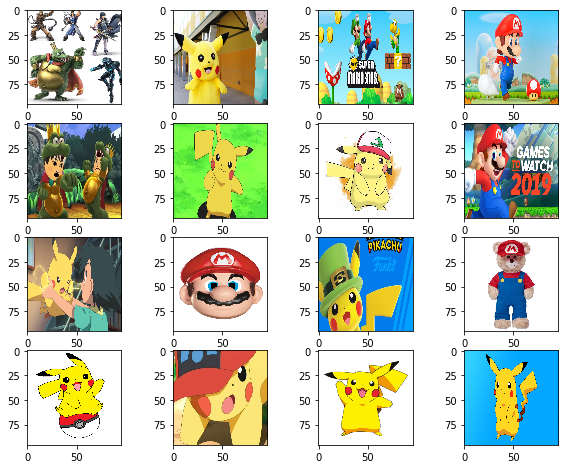

In [13]:
#Test randomly chosen images from the array representation
fig = plt.figure(figsize=(10,8))
cols = 4
rows = 4
for x in range(1,cols*rows +1):
    fig.add_subplot(rows,cols,x)
    plt.imshow(images_data_scaled[random.randrange(character_dict['Total'])])

#### **Binarizing the Labels**

Binarizing the labels is representing each categorical label with a unique array of binary values. We do this because in multi-class Machine Learning since the neural network will expect the shape of the labels array to match with the number of classes. In our case each label should have a dimension of 3. The label "pikachu" is a one dimensional string whereas [0 0 1] is a 3 dimensional array

In [14]:
#LabelBinarizer is an sklearn function designed to easily transform labels
lb = LabelBinarizer()
labels_binarized = lb.fit_transform(labels)
#Store the original labels in a list
labels_original = lb.inverse_transform(labels_binarized)

Check that originally the label was a string i.e. the name of the character, whereas after the binarization it is represented by an array of binary values

In [15]:
type(labels_original[0]),type(labels_binarized[0])

(numpy.str_, numpy.ndarray)

I want to see how the Binarizer represented each character. So I will go through the original labels and for each character return the index number of the first time they appear in the list.

In [16]:
#Return the index of the original labels by finding the first label index for each character
characters = ["mario","pikachu","kingkrool"]
label_indices = []
for ch in characters:
    label_indices.append(list(labels_original).index(ch))
label_indices

[0, 1, 8]

So the first time "mario" appeared in the original labels list was at index 0, which is the 1st element in the list.<br> 
I created the original labels list and list of binary arrays together, so they correspond. Using the indices obtained above from the original labels list, I can look up the corresponding binary representation in the binarized labels list.

In [17]:
for labIndex in label_indices:
    print(labels_original[labIndex],":",labels_binarized[labIndex])

mario : [0 1 0]
pikachu : [0 0 1]
kingkrool : [1 0 0]


Now we know which binary representation correspods to which character

### **3. Test/Train Partition**

I will partition the data into test and train sets by using 15% of the entire dataset for testing

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_data_scaled, labels_binarized, test_size=0.15,
                                                   random_state = 42)

### **4. Image Augmentation**

Image Augmentation is manipulating and transforming images using various methods to increase the size of our training set, which strengthens the models predictive ability. We will use the ImageDataGenerator function from keras to generate the augmented images. The parameter values vary, but there are commonly used values in most projects. The values can be adjusted to obtain the lowest error rate, however should not be expected to yield a significant change.

In [19]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [20]:
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                            height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                            horizontal_flip=True, fill_mode="nearest")

### **5. Building the CNN Model**

In [2]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import img_to_array, array_to_img

Using TensorFlow backend.


In [22]:
#This line hides the tf deprecation warnings which appear because we are using Tensorflow 1.x syntax in the newer Tensorflow 2.0 
#Even if you get the warnings, the model will still build as they are just recommendations to use the new syntax not code errors
tf.logging.set_verbosity(tf.logging.ERROR)

In [23]:
model = keras.models.Sequential()

In [25]:
model.add(Conv2D(32,(3,3), input_shape = (96,96,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
#Dropout works by randomly disconnecting nodes from the current layer to the next layer. dropout of 25% reduces over-fitting
model.add(Dropout(rate=0.25))

In [26]:
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [27]:
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [28]:
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#We have 3 different classes of smashbros characters
classes=3
model.add(Dense(classes, activation = 'softmax'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
__________

### **6. Train the Model**

Compile the model first. For the loss function we are using categorical crossentropy as we have more than two classes. If you have only two classes you may use binary_crossentropy.
We want the model to be evaluated based on accuracy. Adam is a popular stochastic gradient descent method and produces effective results in image recognition models. For further details check: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [30]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"])

#### Explaining Batch

Because the size of our training data is very large instead of passing the entire data into the neural network at once, we split it into a **Number of Batches**. The number of samples in each batch is determined by the **Batch Size**. Note that the Number of Batches and Batch Size are different things.

#### Explaining Epoch
The Epoch value determines how many times our network “sees” the training set and learns patterns from it. One Epoch is when **the entire dataset is propagated forward and backward through the neural network** once. At each epoch the weights used in the model are optimized using a Gradient Descent algorithm (refer to online sources for more detail). Too few optimization can cause underfitting whereas too much can cause overfitting. The computation times increases as the number of epochs increases.

#### **Testing Models**

I tested three models: 
1. Batch Size of 32 and 20 epochs
2. Batch Size of 32 and 30 epochs
3. Batch Size of 64 and 50 epochs


With the third model I achieved approximately 97% accuracy on the training set and 89% on the testing set. With further parameter tuning it is possible to improve the performance. However considering the limited size of the data, I would say 99% accuracy is quite good. <br>
I commented out the first two models but kept the third one.

In [36]:
# batchSize = 32
# epochNum = 20
# smash_model1 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batchSize), 
#                                    validation_data = (X_test, y_test),
#                                    steps_per_epoch = len(X_train) // batchSize,
#                                    epochs = epochNum, verbose = 1)

In [ ]:
# batchSize2 = 32
# epochNum2 = 30
# smash_model2 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batchSize2), 
#                                    validation_data = (X_test, y_test),
#                                    steps_per_epoch = len(X_train) // batchSize2,
#                                    epochs = epochNum2, verbose = 1)

In [32]:
batchSize3 = 64
epochNum3 = 50
smash_model = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batchSize3), 
                                   validation_data = (X_test, y_test),
                                   steps_per_epoch = len(X_train) // batchSize3,
                                   epochs = epochNum3, verbose = 1)

Epoch 1/50
9/9 [==============================] - 31s 3s/step - loss: 0.0852 - acc: 0.9688 - val_loss: 0.4219 - val_acc: 0.9057
Epoch 2/50
9/9 [==============================] - 40s 4s/step - loss: 0.1020 - acc: 0.9605 - val_loss: 0.3740 - val_acc: 0.9057
Epoch 3/50
9/9 [==============================] - 45s 5s/step - loss: 0.0560 - acc: 0.9710 - val_loss: 0.3910 - val_acc: 0.9151
Epoch 4/50
9/9 [==============================] - 35s 4s/step - loss: 0.0403 - acc: 0.9860 - val_loss: 0.3444 - val_acc: 0.9434
Epoch 5/50
9/9 [==============================] - 35s 4s/step - loss: 0.0878 - acc: 0.9682 - val_loss: 0.4744 - val_acc: 0.9057
Epoch 6/50
9/9 [==============================] - 30s 3s/step - loss: 0.0814 - acc: 0.9668 - val_loss: 0.4863 - val_acc: 0.9057
Epoch 7/50
9/9 [==============================] - 44s 5s/step - loss: 0.0591 - acc: 0.9727 - val_loss: 0.4758 - val_acc: 0.8962
Epoch 8/50
9/9 [==============================] - 81s 9s/step - loss: 0.0560 - acc: 0.9769 - val_loss: 0

In [1]:
#saving the model weights for later use
model.save('final_model.h5')

NameError: name 'model' is not defined